In [ ]:
from _global_vars import *
import seaborn as sns
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

In [2]:
# read in data
sdf_filtered = spark.read.parquet('../data/curated/yt2019_cleaned.parquet')
print(sdf_filtered.count())
#sdf.show(1, vertical=True, truncate=100)

### Taking a look at fare_per_minute (fpm)

In [4]:
sdf_filtered.describe('fare_per_minute').show()

+-------+-------------------+
|summary|    fare_per_minute|
+-------+-------------------+
|  count|           66354904|
|   mean| 0.9369516222122509|
| stddev| 0.2426412699227397|
|    min|0.05341355599214146|
|    max| 38.990697674418605|
+-------+-------------------+



In [5]:
avg_fpm_weekday = sdf_filtered.groupBy('PU_dayofweek') \
            .agg(
                { 'fare_per_minute' : 'mean', }
                ) \
            .toPandas()

<AxesSubplot:xlabel='PU_dayofweek', ylabel='avg(fare_per_minute)'>

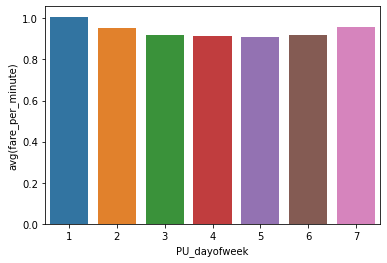

In [7]:
sns.barplot(x=avg_fpm_weekday['PU_dayofweek'],
            y=avg_fpm_weekday['avg(fare_per_minute)'])

In [8]:
sdf_filtered.select('fare_per_minute').sort(F.desc('fare_per_minute')).show()

+------------------+
|   fare_per_minute|
+------------------+
|38.990697674418605|
|38.990697674418605|
|27.783251231527093|
|27.783251231527093|
| 25.57377049180328|
| 25.54945054945055|
|24.566929133858267|
| 23.11111111111111|
|21.224489795918366|
|21.224489795918366|
|20.662251655629138|
|              20.0|
|              20.0|
|19.024390243902438|
|19.024390243902438|
| 18.24561403508772|
|             16.25|
|             16.25|
|14.854455445544554|
| 13.68421052631579|
+------------------+
only showing top 20 rows



### Bivariate Analysis

In [9]:
# subsample from the filtered and clean data ->
sdf_samp = sdf_filtered.sample(fraction=0.001, seed=0)
print(sdf_samp.count())

65825

Fare amount by year

In [10]:
# https://www.kaggle.com/code/nicapotato/taxi-rides-time-analysis-and-oof-lgbm/notebook
def time_slicer(df, timeframes, value, color="purple"):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(2,2, figsize = [12,6])
    i = 0
    j = 0

    for o, x in enumerate(timeframes):

        df.loc[:,[x,value]].groupby([x]).mean().plot(ax=ax[i,j],color=color)
        ax[i,j].set_ylabel(value.replace("_", " ").title())
        ax[i,j].set_title("{} by {}".format(value.replace("_", " ").title(), x.replace("_", " ").title()))
        ax[i,j].set_xlabel("")

        # bit rudimentary here by me, why not use zip
        if i == 0 and j == 0:
            i = 1
            j = 0
        elif i == 1 and j == 0:
            i = 0
            j = 1

        elif i == 0 and j == 1:
            i = 1
            j = 1
    plt.tight_layout(pad=0)
    pass


In [11]:
# convert to pd for visualisation
df_pu_fare_by_time = sdf_samp.select(['PU_dayofmonth',
                                      'PU_dayofweek',
                                      'PU_hourofday',
                                      'PU_month',
                                      'fare_amount',
                                      'trip_distance']).toPandas()

df_do_fare_by_time = sdf_samp.select(['DO_dayofmonth',
                                      'DO_dayofweek',
                                      'DO_hourofday',
                                      'DO_month',
                                      'fare_amount',
                                      'trip_distance']).toPandas()

In [ ]:
time_slicer(df = df_pu_fare_by_time,
            timeframes = ['PU_hourofday',
                          'PU_dayofweek',
                          'PU_dayofmonth',
                          'PU_month'],
            value = 'fare_amount',
            color="blue")

In [ ]:
time_slicer(df = df_pu_fare_by_time,
            timeframes = ['PU_hourofday',
                          'PU_dayofweek',
                          'PU_dayofmonth',
                          'PU_month'],
            value = 'trip_distance',
            color="red")

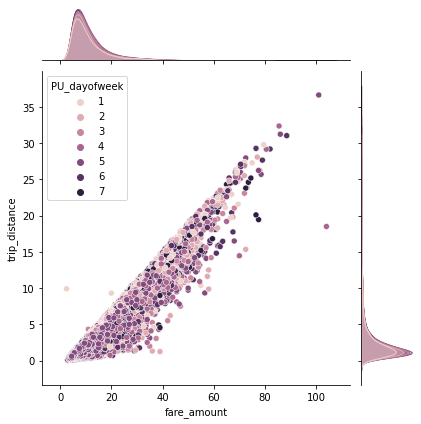

In [15]:
# more random pltos
sns.jointplot(x=df_pu_fare_by_time['fare_amount'],
              y=df_pu_fare_by_time['trip_distance'],
              hue=df_pu_fare_by_time['PU_dayofweek'])

In [16]:
spark.sql("CLEAR CACHE")
spark.stop()